In [ ]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import statsmodels.api as sm

import kagglehub
import zipfile
import os

# Baixar o dataset com kagglehub
path = kagglehub.dataset_download("sureshgupta/health-insurance-data-set")

print("Path to dataset files:", path)

# Verificar arquivos baixados
print("Arquivos baixados:", os.listdir(path))

# Descompactar o arquivo ZIP (se houver)
for file in os.listdir(path):
    if file.endswith(".zip"):
        zip_path = os.path.join(path, file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(path)
        print("Arquivos extraídos:", os.listdir(path))


Path to dataset files: /kaggle/input/health-insurance-data-set
Arquivos baixados: ['1651277648862_healthinsurance.csv']


In [ ]:
# Carregar os dados
csv_path = os.path.join(path, '1651277648862_healthinsurance.csv')
df = pd.read_csv(csv_path)
df = df.drop(columns=['job_title'])
df.head()

,age,sex,weight,bmi,hereditary_diseases,no_of_dependents,smoker,city,bloodpressure,diabetes,regular_ex,claim
0,60.0,male,64,24.3,NoDisease,1,0,NewYork,72,0,0,13112.6
1,49.0,female,75,22.6,NoDisease,1,0,Boston,78,1,1,9567.0
2,32.0,female,64,17.8,Epilepsy,2,1,Phildelphia,88,1,1,32734.2
3,61.0,female,53,36.4,NoDisease,1,1,Pittsburg,72,1,0,48517.6
4,19.0,female,50,20.6,NoDisease,0,0,Buffalo,82,1,0,1731.7


In [ ]:
# Carregar e explorar a base de dados
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  14604 non-null  float64
 1   sex                  15000 non-null  object 
 2   weight               15000 non-null  int64  
 3   bmi                  14044 non-null  float64
 4   hereditary_diseases  15000 non-null  object 
 5   no_of_dependents     15000 non-null  int64  
 6   smoker               15000 non-null  int64  
 7   city                 15000 non-null  object 
 8   bloodpressure        15000 non-null  int64  
 9   diabetes             15000 non-null  int64  
 10  regular_ex           15000 non-null  int64  
 11  claim                15000 non-null  float64
dtypes: float64(3), int64(6), object(3)
memory usage: 1.4+ MB


,0
age,396
sex,0
weight,0
bmi,956
hereditary_diseases,0
no_of_dependents,0
smoker,0
city,0
bloodpressure,0
diabetes,0


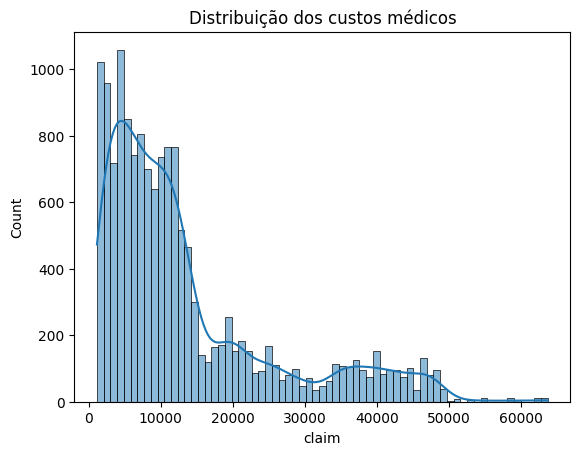

In [ ]:
# Distribuição dos custos médicos
sns.histplot(df['claim'], kde=True)
plt.title('Distribuição dos custos médicos')
plt.show()

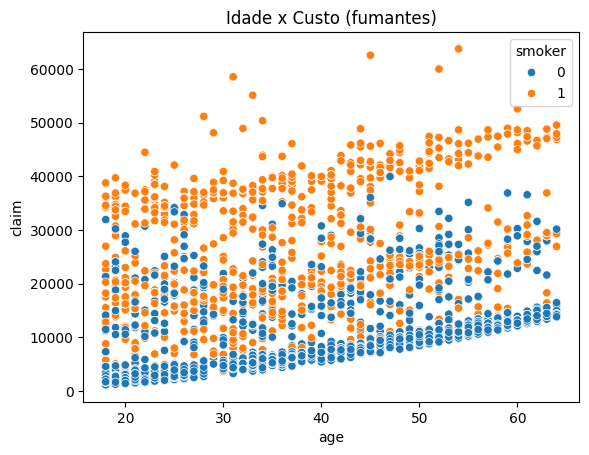

In [ ]:
# Relação entre idade e custo
sns.scatterplot(data=df, x='age', y='claim', hue='smoker')
plt.title('Idade x Custo (fumantes)')
plt.show()

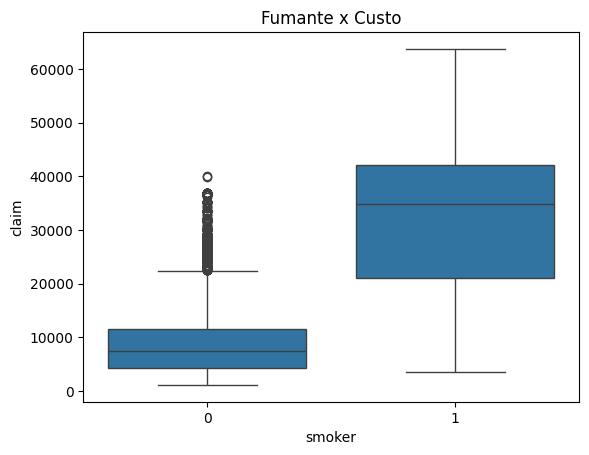

In [ ]:
# Boxplot por fumante
sns.boxplot(data=df, x='smoker', y='claim')
plt.title('Fumante x Custo')
plt.show()

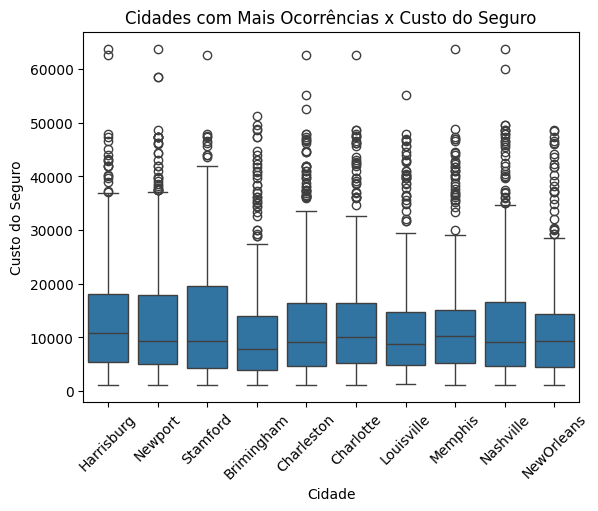

In [ ]:
df['city'].value_counts().head(10)
top_cities = df['city'].value_counts().head(10).index  # 10 cidades mais comuns
df_top = df[df['city'].isin(top_cities)]
sns.boxplot(data=df_top, x='city', y='claim')
plt.title('Cidades com Mais Ocorrências x Custo do Seguro')
plt.xlabel('Cidade')
plt.ylabel('Custo do Seguro')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Remove valores ausentes
df.isnull().sum()

# Detecção e tratamento de inconsistências
df['sex'] = df['sex'].str.lower()
df['city'] = df['city'].str.lower().str.strip()

# Verificar duplicatas
df.duplicated().sum()
df = df.drop_duplicates()

# Tratar valores inválidos ou fora do domínio
df = df[df['age'] >= 18]
df = df[df['bmi'].between(10, 60)]
df = df[df['no_of_dependents'] >= 0]

In [ ]:
# Excluir 'city' antes da codificação
df_para_codificar = df.drop(columns=['city', 'hereditary_diseases'])

# Aplicar one-hot encoding apenas nas colunas restantes
df_encoded = pd.get_dummies(df_para_codificar, drop_first=True)

# Adicionar a coluna 'city' de volta (opcional, se quiser manter no DataFrame final)
df_encoded['city'] = df['city'].values
df_encoded['hereditary_diseases'] = df['hereditary_diseases'].values

df_encoded.head()


,age,weight,bmi,no_of_dependents,smoker,bloodpressure,diabetes,regular_ex,claim,sex_male,city,hereditary_diseases
0,60.0,64,24.3,1,0,72,0,0,13112.6,True,newyork,NoDisease
1,49.0,75,22.6,1,0,78,1,1,9567.0,False,boston,NoDisease
2,32.0,64,17.8,2,1,88,1,1,32734.2,False,phildelphia,Epilepsy
3,61.0,53,36.4,1,1,72,1,0,48517.6,False,pittsburg,NoDisease
4,19.0,50,20.6,0,0,82,1,0,1731.7,False,buffalo,NoDisease


In [ ]:
# Separar features e target
X = df_encoded.drop(columns=['claim', 'city', 'hereditary_diseases'])  # city fora do modelo
y = df_encoded['claim']
df.head()

,age,sex,weight,bmi,hereditary_diseases,no_of_dependents,smoker,city,bloodpressure,diabetes,regular_ex,claim
0,60.0,male,64,24.3,NoDisease,1,0,newyork,72,0,0,13112.6
1,49.0,female,75,22.6,NoDisease,1,0,boston,78,1,1,9567.0
2,32.0,female,64,17.8,Epilepsy,2,1,phildelphia,88,1,1,32734.2
3,61.0,female,53,36.4,NoDisease,1,1,pittsburg,72,1,0,48517.6
4,19.0,female,50,20.6,NoDisease,0,0,buffalo,82,1,0,1731.7


In [ ]:
# Dividir em treino/teste (ANTES de escalar)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Identificar colunas numéricas
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Aplicar StandardScaler só nas colunas numéricas
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
# Treinar o modelo com os dados escalados
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Avaliar a performance
y_pred = model.predict(X_test_scaled)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R²: 0.9609719690497459
MAE: 481.78741348579877
RMSE: 2375.8532318053153


In [ ]:
# Recriar o DataFrame com nomes corretos e garantir tipo numérico
X_ols = pd.DataFrame(X_train_scaled, columns=X_train.columns).reset_index(drop=True).astype(float)
y_train_ols = y_train.reset_index(drop=True).astype(float)

# Adicionar constante (intercepto)
X_const = sm.add_constant(X_ols)

# Rodar regressão OLS
ols_model = sm.OLS(y_train_ols, X_const).fit()

# Exibir resultado
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  claim   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     2833.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:15:20   Log-Likelihood:            -1.0303e+05
No. Observations:               10113   AIC:                         2.061e+05
Df Residuals:                   10103   BIC:                         2.062e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.354e+04     90.044  

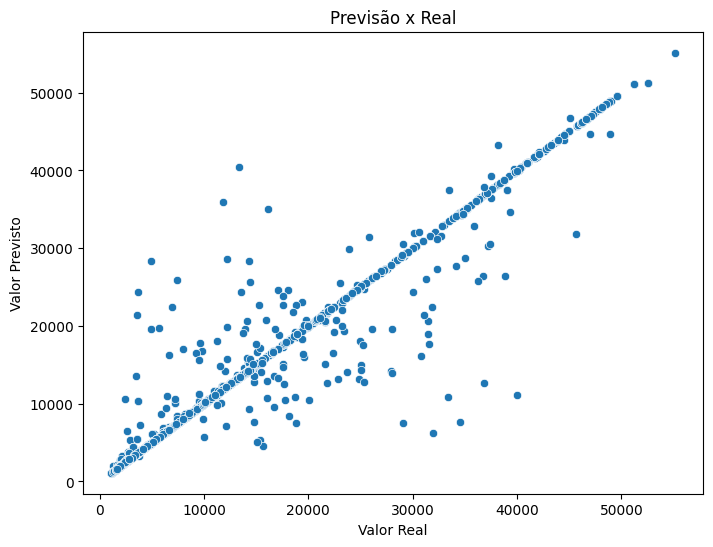

In [ ]:
# Comparar predições com valores reais
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.title("Previsão x Real")
plt.show()

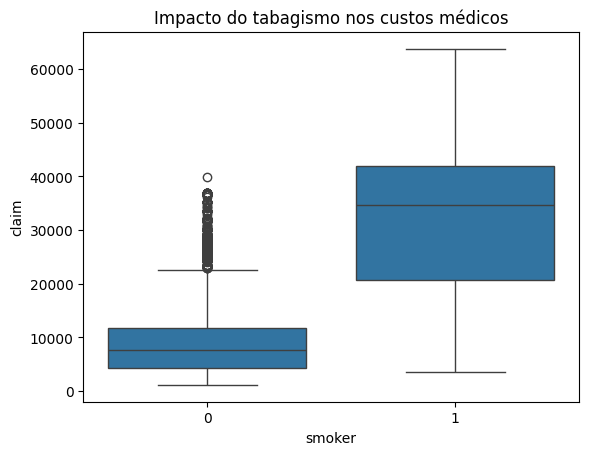

In [ ]:
# Fumante vs não fumante
sns.boxplot(data=df, x='smoker', y='claim')
plt.title('Impacto do tabagismo nos custos médicos')
plt.show()

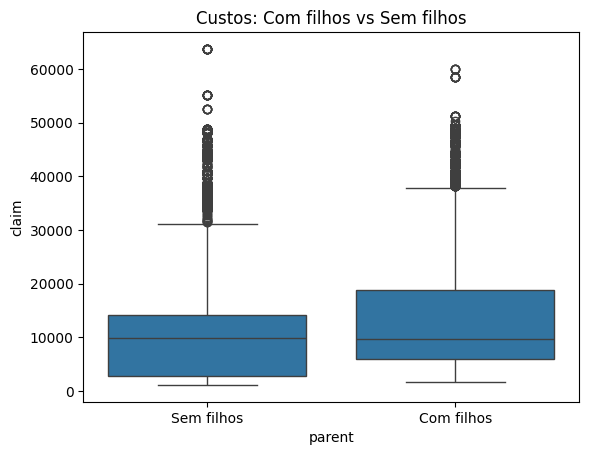

In [ ]:
# Mães (children > 0)
df['parent'] = df['no_of_dependents'] > 0
sns.boxplot(data=df, x='parent', y='claim')
plt.title('Custos: Com filhos vs Sem filhos')
plt.xticks([0, 1], ['Sem filhos', 'Com filhos'])
plt.show()

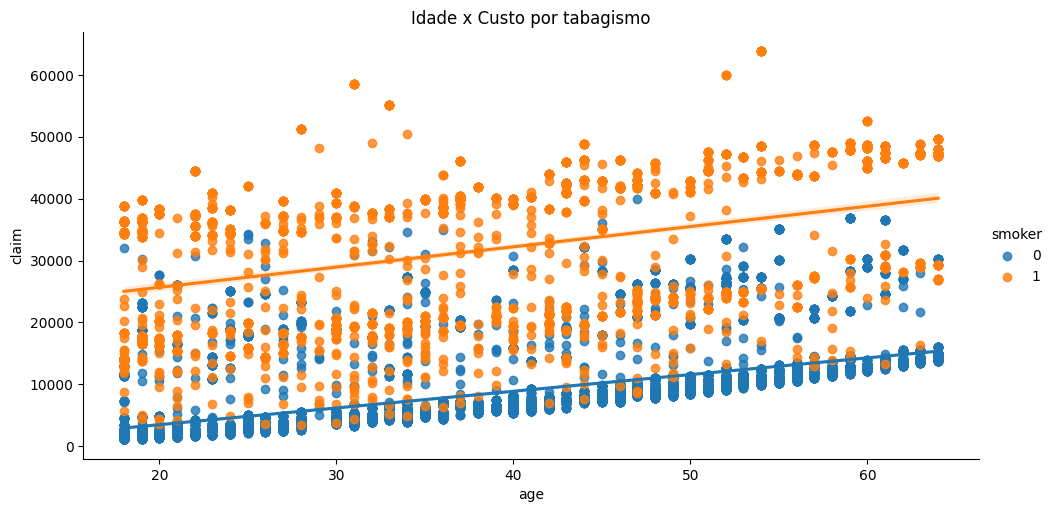

In [ ]:
# Idade vs custo
sns.lmplot(data=df, x='age', y='claim', hue='smoker', aspect=2)
plt.title('Idade x Custo por tabagismo')
plt.show()

In [ ]:
# Remover outliers

# Remover outliers da variável charges
Q1 = df['claim'].quantile(0.25)
Q3 = df['claim'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_sem_outliers = df[(df['claim'] >= limite_inferior) & (df['claim'] <= limite_superior)]

# Remover outliers da variável bmi
Q1_bmi = df['bmi'].quantile(0.25)
Q3_bmi = df['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi
lim_inf_bmi = Q1_bmi - 1.5 * IQR_bmi
lim_sup_bmi = Q3_bmi + 1.5 * IQR_bmi

df_sem_outliers = df_sem_outliers[(df_sem_outliers['bmi'] >= lim_inf_bmi) & (df_sem_outliers['bmi'] <= lim_sup_bmi)]

In [ ]:
# Excluir 'city' antes da codificação
df_para_codificar = df.drop(columns=['city', 'hereditary_diseases'])

# Aplicar one-hot encoding apenas nas colunas restantes
df_encoded = pd.get_dummies(df_para_codificar, drop_first=True)

# Adicionar a coluna 'city' de volta (opcional, se quiser manter no DataFrame final)
df_encoded['city'] = df['city'].values
df_encoded['hereditary_diseases'] = df['hereditary_diseases'].values

df_encoded.head()


,age,weight,bmi,no_of_dependents,smoker,bloodpressure,diabetes,regular_ex,claim,parent,sex_male,faixa_etaria_26-35,faixa_etaria_36-45,faixa_etaria_46-55,faixa_etaria_56-65,city,hereditary_diseases
0,60.0,64,24.3,1,0,72,0,0,13112.6,True,True,False,False,False,True,newyork,NoDisease
1,49.0,75,22.6,1,0,78,1,1,9567.0,True,False,False,False,True,False,boston,NoDisease
2,32.0,64,17.8,2,1,88,1,1,32734.2,True,False,True,False,False,False,phildelphia,Epilepsy
3,61.0,53,36.4,1,1,72,1,0,48517.6,True,False,False,False,False,True,pittsburg,NoDisease
4,19.0,50,20.6,0,0,82,1,0,1731.7,False,False,False,False,False,False,buffalo,NoDisease


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test_scaled)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R²: 0.9609719690497459
MAE: 481.78741348579877
RMSE: 2375.8532318053153


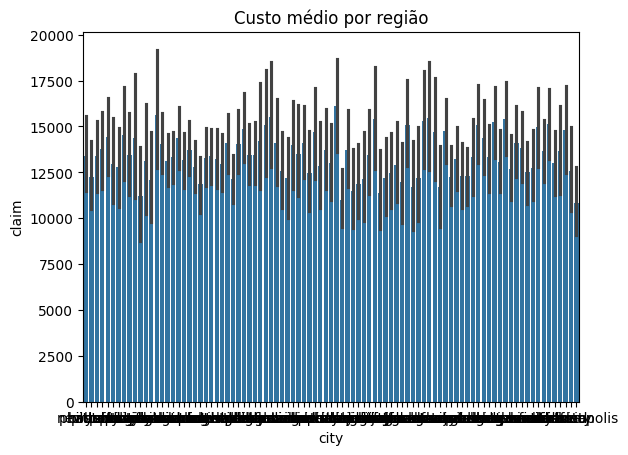

In [ ]:
# Custo médio por região
sns.barplot(x='city', y='claim', data=df)
plt.title('Custo médio por região')
plt.show()

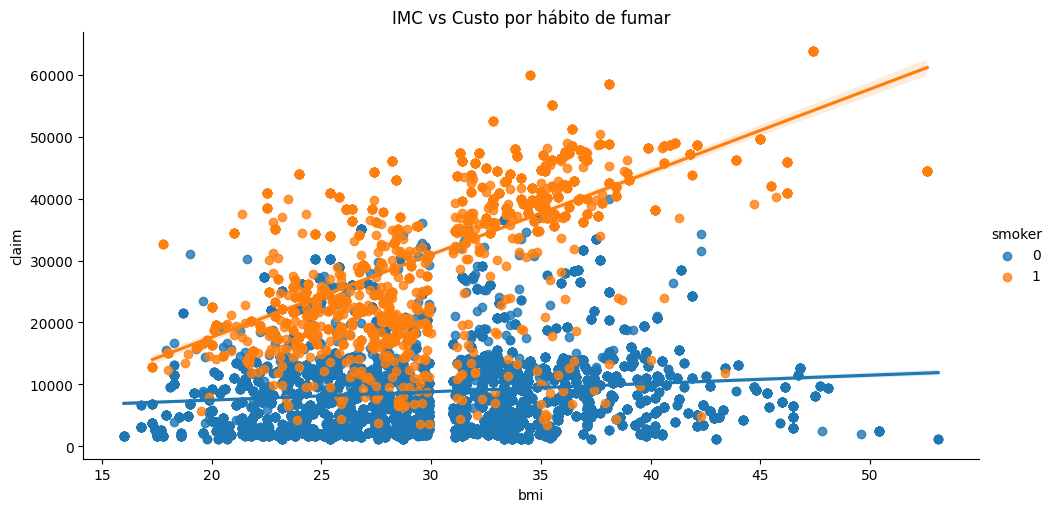

In [ ]:
# Impacto do IMC em fumantes vs não fumantes
sns.lmplot(data=df, x='bmi', y='claim', hue='smoker', aspect=2)
plt.title("IMC vs Custo por hábito de fumar")
plt.show()

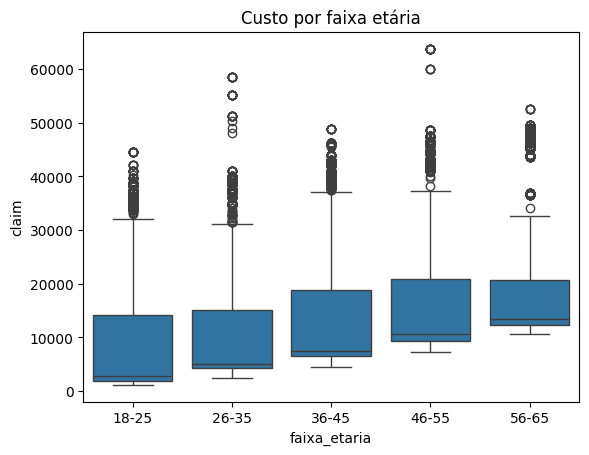

In [ ]:
# Distribuição dos custos por faixa etária
df_encoded['faixa_etaria'] = pd.cut(df['age'], bins=[17, 25, 35, 45, 55, 65], labels=['18-25', '26-35', '36-45', '46-55', '56-65'])
sns.boxplot(x='faixa_etaria', y='claim', data=df)
plt.title("Custo por faixa etária")
plt.show()

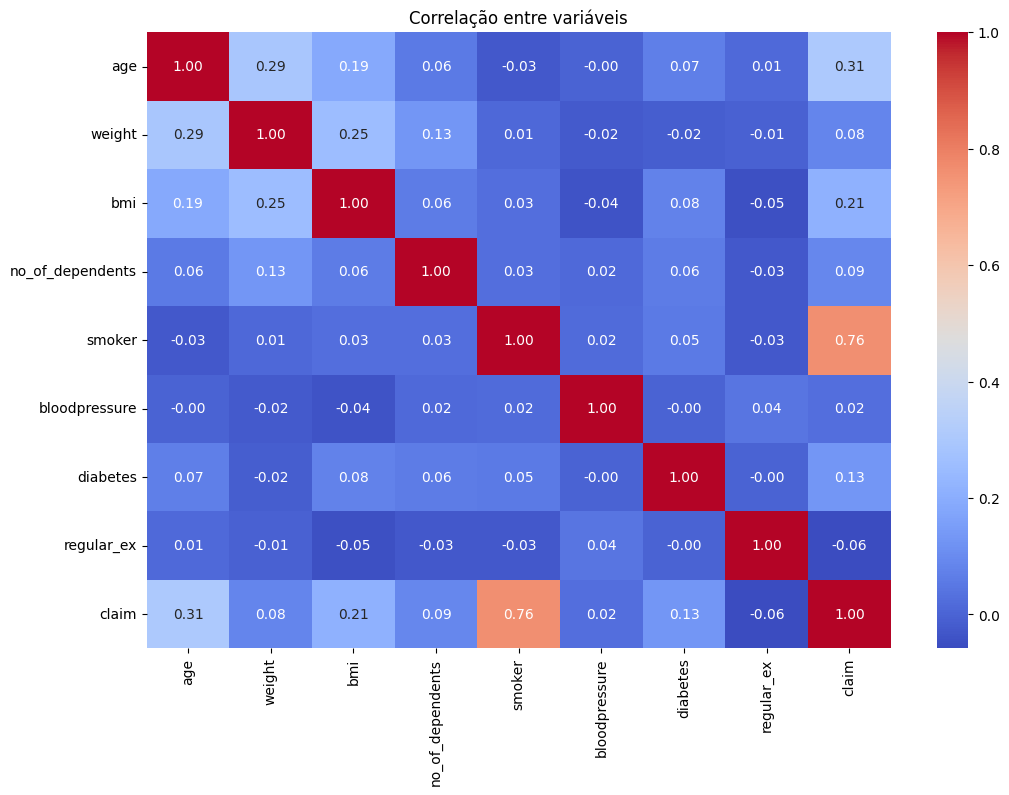

In [ ]:
# Gerar correlação apenas com colunas numéricas
corr_matrix = df_encoded.select_dtypes(include=[np.number]).corr()

# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlação entre variáveis")
plt.show()

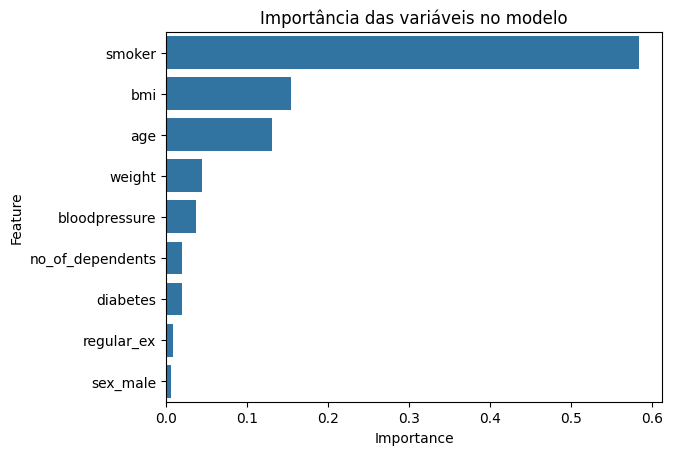

In [ ]:
# Gráfico de importância das variáveis (Random Forest)
importances = model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Importância das variáveis no modelo")
plt.show()